<a href="https://www.kaggle.com/code/yaaangzhou/learning-llm-finetune-with-lora?scriptVersionId=142017144" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[Learning LLM]Finetune with LoRA**

**4 Sep 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">[Learning LLM]Finetune LLMs with LoRA</center>

This is a study note based on the public kernal. Thank you for all the support.
***

# 1. What is LoRA？

Large language models (LLM) are known for being expensive to train, fine-tune, and run. It was thought that it takes models with hundreds of billions of parameters trained with millions of dollars’ worth of compute to match the capabilities of GPT-3.5 and ChatGPT.

However, recently released open-source LLMs have proven that you don’t need very large models to compete with the state of the art. Researchers have trained LLMs with a few billion parameters to perform at a level that is comparable to very large models. The success of open-source large language models has sparked interest and growing activity in the field.

Some of these efforts focus on making the fine-tuning of LLMs more cost-efficient. One of the techniques that helps reduce the costs of fine-tuning enormously is “low-rank adaptation” (LoRA). With LoRA, you can fine-tune LLMs at a fraction of the cost it would normally take.

In [1]:
%pip install peft==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
mkdir cache

In [3]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
data = load_dataset("Abirate/english_quotes", cache_dir="../working/cache"+"/datasets")
data = data.map(lambda samples: tokenizer(samples["quote"]), batched=True)
train_sample = data["train"].select(range(50))
display(train_sample) 

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to ../working/cache/datasets/json/Abirate--english_quotes-7ef692ccb59fbf2a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['quote', 'author', 'tags', 'input_ids', 'attention_mask'],
    num_rows: 50
})

## What is the principle of LoRA?

The core idea of LoRA is that the parameter updates of LLMs for specific downstream tasks are usually low-rank. Therefore, LoRA simulates the parameter updates by low-rank decomposition, which can achieve indirect training of large models with extremely small parameter sizes.

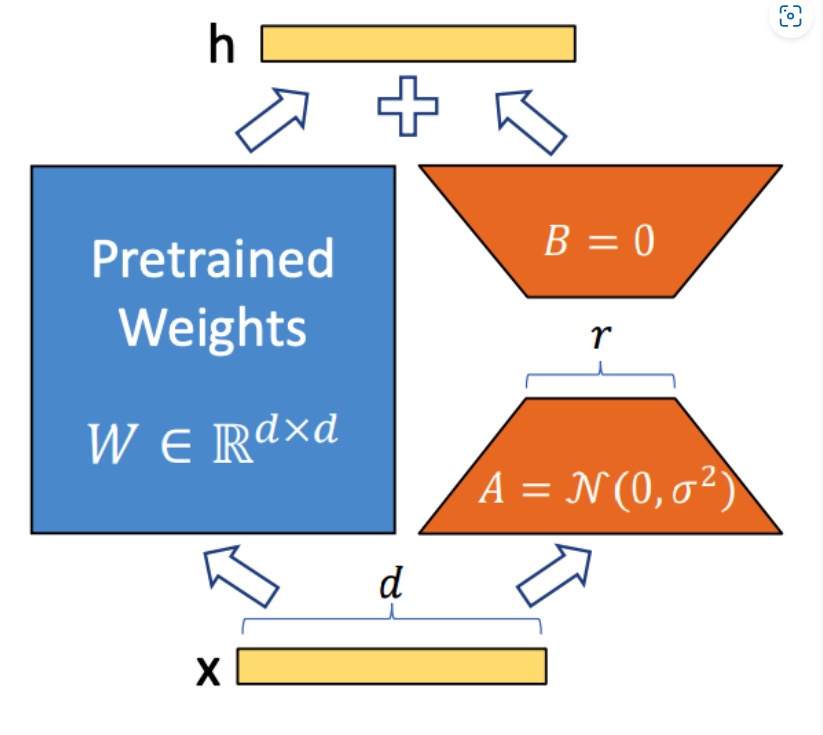

# 2. Train a PEFT Model

This step consists of the following steps:
1. Set training parameters
2. Set up training model
3. Start training

In [5]:
import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=4, # rank of the matriz, 4-8 should be good
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], 
    lora_dropout=0.05, 
    bias="none", # this specifies if the bias parameter should be trained. 
    task_type="CAUSAL_LM" # type of task
)

peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


In [6]:
import transformers
from transformers import TrainingArguments, Trainer
import os

output_directory = os.path.join("../cache/working", "peft_lab_outputs")
training_args = TrainingArguments(
    report_to="none",
    output_dir=output_directory,
    auto_find_batch_size=True,
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=5,
    no_cuda=True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1252: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


PS:The **DataLoader** is responsible for reading batch data from the data set, and the **DataCollator** is responsible for organizing the batch data.

In [7]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False) 
)
trainer.train()

You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=35, training_loss=3.267395455496652, metrics={'train_runtime': 1275.8342, 'train_samples_per_second': 0.196, 'train_steps_per_second': 0.027, 'total_flos': 61919258443776.0, 'train_loss': 3.267395455496652, 'epoch': 5.0})

# 3. Save Parameters

In [8]:
import time

time_now = time.time()
peft_model_path = os.path.join(output_directory, f"peft_model_{time_now}")
trainer.model.save_pretrained(peft_model_path)

# 4. Load Final Model

Now we can load the foundation_model and weights that we just trainned.

In [9]:
from peft import PeftModel, PeftConfig

loaded_model = PeftModel.from_pretrained(foundation_model, peft_model_path, 
                                        is_trainable=False)

# 5. Inference

Now we can proceed to the inference task.

The task of this inference is to generate a text related to the input text.

In [10]:
inputs = tokenizer("Be or not to be, ", return_tensors="pt")

In [11]:
outputs = peft_model.generate(
    input_ids=inputs["input_ids"], 
    attention_mask=inputs["attention_mask"],
    max_new_tokens=10,
    eos_token_id=tokenizer.eos_token_id
    )

print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

['Be or not to be,  but to be loved, to be loved by those']
